# Converting between Ising and flux schedules for multiqubit systems

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import quack.schedule.multi_qubit as sims
import importlib
import pickle

This notebook includes examples on how to calculate Ising schedules for given fluxes, and how to calculate fluxes for given Ising schedules.

## Example for a chain of three qubits

### creating the circuit object

Here we consider a chain of three qubit that are coupled via two tunable couplers, one of them is coupled ferromagnetically (negative ZZ sign) and the other is coupled anti-ferromagnetically (positive ZZ sign).
First, let us create the qubit and coupler objects, using typical parameters of Indus.
Note that here we use symmetric junctions with `d=0`.

In [2]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit2 = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = sims.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = sims.Coupler(i_sigma, c_sigma, lc, d)

After creating the circuit objects, we should put them in a list `elements` that holds them and essentially assigns indexes to them

In [3]:
elements = [qubit0, coupler01, qubit1, coupler12, qubit2]

Having our qubits and coupler in this list, we will now have to set the mutuals between them to construct the mutual matrix `m_mat` between them.
For that, if `elements[i]` and `elements[i]` circuit elements are coupled via a mutual inductance of `m`, then for the mutual matrix we should have `m_mat[i, j] = m_mat[j, i] = -m` (notice the negative sign).
Note that the size of (both of axis of the) mutual matrix is the same as the size of the `elements`.
Therefore for a chain configuration we have:

In [4]:
m = 65; m_mat = np.zeros((5, 5));

m_mat[0, 1] = m; m_mat[1, 2] = m;
m_mat[2, 3] = -m; m_mat[3, 4] = m;

m_mat = -(m_mat + m_mat.T)

The last part is to choose a truncation size for the circuit elements.
This assigns a truncation size to each object in the `elements`, which means how many low-energy eigenstates and eigenvalues of the system to keep when calculating the joint Hamiltonian of the system (or subsystems).
Here I use a smaller truncation for couplers compared to qubits, cause couplers have higher frequencies.

In [5]:
trunc_vec = np.array([6, 3, 6, 3, 6])

We have now all the required elements to create our circuit object which we'll use for all the calculations

In [6]:
circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

## Calculating Ising schedules for given circuit biases

To calculate the schedules using the circuit biases, we first have to construct a dictionary of the circuit fluxes.
This dictionary will have a key named `points` which simply is the number of points used for the flux schedules.
For circuit element i (`elements[i]`), the x and z biases should have keys of `"phix_i"` and `"phiz_i"` respectively.
This keys then are assigned to an array of flux points.
The input for circuit biases are phase, i.e., $\varphi = \frac{\Phi}{\Phi_0}2\pi$ where $\varphi$ is the phase and $\Phi$ is the magnetic flux.

Note that we use the annealing region near $\Phi_z = 0$, and NOT $\Phi_z = \Phi_0/2$.
Below we use some simple circuit biases that change linearly during the anneal.

In [7]:
phi_dict = {}; pts = 20;
s = np.linspace(0, 1, pts)
phi_dict["points"] = pts

phi_dict["phix_0"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_1"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_2"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_3"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_4"] = np.linspace(0.75, 1, pts)*2*np.pi

phi_dict["phiz_0"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_1"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_2"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_3"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_4"] = np.linspace(0, 0.002, pts)*2*np.pi

We can then use the different methods of the system to calculate the Ising coefficients.

### Ising via full Schrieffer–Wolff (SW)
The full Schrieffer–Wolff method [arXiv:1912.00464](https://arxiv.org/abs/1912.00464) is the most accurate method in this module, but it will not work for large systems.
This method essentially has to construct the Hamiltonian of the whole system and diagonalize it.
Therefore the computational cost scales exponentially with the number of qubits and coupler circuit elements.
Nevertheless, for our small circuit here we can do it via the `get_ising_sw` method:

In [10]:
%%time

ising_sw_dict = circuit.get_ising_sw(phi_dict, verbose=True)

CPU times: user 23min 42s, sys: 7min 58s, total: 31min 41s
Wall time: 3min 32s


### Ising via pair-wise Schrieffer–Wolff (PWSW)
The pair-wise Schrieffer–Wolff method is an approximate method to calculate the Ising coefficients.
In this method the single qubit Ising terms are calculated using single qubit flux biases, and then to calculate the interaction between qubits we form subcircuits of qubit-coupler-qubit and use full SW on these subsystems to calculate the interaction between qubit pairs.
The computational cost of this method scales linearly with the number of qubits and coupler circuit elements, and therefore is suitable for large circuits.
We can use this method via the `get_ising_pwsw` method as:

In [8]:
%%time

ising_pwsw_dict = circuit.get_ising_pwsw(phi_dict, verbose=True)

calculating qubit isings for qubit 1 of 3
calculating qubit isings for qubit 2 of 3
calculating qubit isings for qubit 3 of 3
calculating coupling strength for coupler 1 of 2
calculating coupling strength for coupler 2 of 2
CPU times: user 4min 23s, sys: 4min 26s, total: 8min 50s
Wall time: 1min 10s


### Output of methods

The output of both methods is a dictionary that included the calculated Ising coefficients using these methods.
The key `"points"` simply includes an integer showing the number of points in the schedule.
Qubits are indexed from 0 to N, and the single qubit Ising terms of them are saved as arrays with the keys `"x_i"` and `"z_i"` where `i` is the index of the qubit.
The interaction terms between qubits `i` and `j` are saved in the keys `"zz_i,j"` where always `i<j`.
The Ising coefficients will be angular frequencies in units of GHz, meaning $\omega = 2\pi f$.

In [9]:
ising_pwsw_dict.keys()

dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'zz_0,1', 'zz_1,2', 'points'])

Below we show the results for the Ising coefficients calcualte via these two methods, where the solid lines are calculated using full SW, while dashed lines are calculated using the pair-wise SW method.

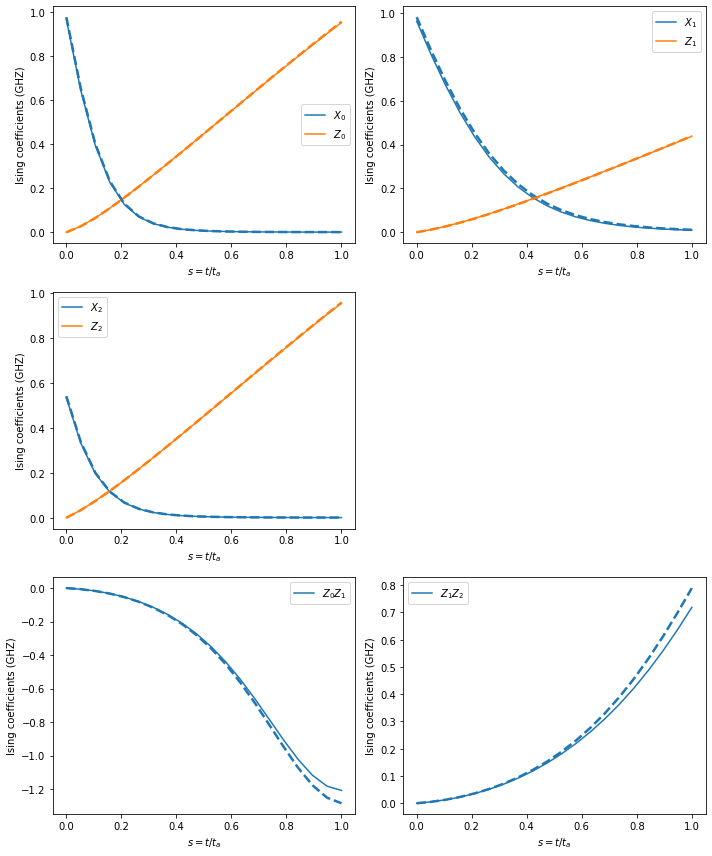

In [14]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(3):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.plot(s, ising_sw_dict["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, ising_sw_dict["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")
    
    plt.plot(s, ising_pwsw_dict["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_pwsw_dict["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
    plt.plot(s, ising_sw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]))
    
    plt.plot(s, ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

## Calculating circuit fluxes for a given Ising schedule

In this part, we want to find the appropriate circuit biases that yields a desired Ising schedule that we want.
For that let us use an Ising schedule that changes linearly with the anneal time.
We have to construct the dictionary for this schedule, with the key assignment the same as the ones that the methods of the previous sections were outputting.
The Ising coefficients should be angular frequencies in units of GHz, meaning $\omega = 2\pi f$.

In [16]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

ising_dict["x_0"] = np.linspace(1, 0, pts)*2*np.pi
ising_dict["x_1"] = np.linspace(0.8, 0, pts)*2*np.pi
ising_dict["x_2"] = np.linspace(0.7, 0.05, pts)*2*np.pi

ising_dict["z_0"] = np.linspace(0.0, 1, pts)*2*np.pi
ising_dict["z_1"] = np.linspace(0, 0.8, pts)*2*np.pi
ising_dict["z_2"] = np.linspace(0, 0.9, pts)*2*np.pi

ising_dict["zz_0,1"] = -np.linspace(0.0, 0.9, pts)*2*np.pi
ising_dict["zz_1,2"] = np.linspace(0.0, 0.8, pts)*2*np.pi

### Circuit fluxes via numerical optimization using full SW

For this, we construct the Ising coefficients using the full SW method, and then use optimization algorithms to find fluxes that minimize the distance between calculated Ising and desired Ising schedules.
Since this uses the full SW method its computational cost scales exponentially with the number of qubits and couplers.
Even worse, the algorithm will construct the full SW of the system multiple times at each point, which makes it take much longer to compute (note the wall time for the following cell).
Of course this method only works for small circuits, but nevertheless it is invoked via the `get_custom_fluxes_num` method.
The `optimizer_method` argument tells what optimization algorithm to use for this routine, and experience shows `'leastsq'` is decent method for most cases.

In [18]:
%%time

custom_flux_dict_num = circuit.get_custom_fluxes_num(ising_dict, verbose=True, optimizer_method="leastsq")

point #10 residual norm: hedule point 10 / 10
 0.020865917874178148  (GHz) 

CPU times: user 19h 11min 53s, sys: 6h 9min 1s, total: 1d 1h 20min 54s
Wall time: 2h 46min 9s


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/multi_qubit.py:1321: UserWarning: For the point #10, solver found solutions that are not optimal. The relative error is 1.06 %
  ).format(p + 1, rel_error * 100)


### Circuit fluxes via pair-wise SW

This uses the pair-wise SW method to calculate the appropriate circuit biases that yields our desired schedules.
For that, the qubit x and z biases are calculated so that it yields our desired single qubit Ising terms.
These single qubit x and z biases are found by numerically optimizing the qubit circuit biases to find the ones that yields our desired Ising coefficients.
For the coupler bias, its z-bias is always kept at degeneracy, and for its x-bias, we form pairs of qubit-coupler-qubit, construct SW for that pair and calculate the interaction between them. Then we use this as a kind of "look-up table" to find the coupler x-bias that yields our desired interaction.
This method only scales linearly with the number of qubit and coupler circuits, therefore it can be used for large circuits.
For that we use the `get_custom_fluxes_pwsw` method of this module.
The `optimizer_method` argument tells what optimization algorithm to use for single qubit flux extraction, and `"leastsq"` is a good method for that.

In [17]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 3
point #9 single qubit residuals: 
 [-9.42860569e-02  6.53953948e-05] 

calculating qubit biases for qubit 2 of 3


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.33211153e-02  5.81214673e-05] 

calculating qubit biases for qubit 3 of 3


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.86 % for single qubit residuals
  ).format(i, rel_error * 100)


schedule point 10 / 10
 calculating coupler bias for coupler 1 of 2
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 2
CPU times: user 20min 27s, sys: 20min 35s, total: 41min 3s
Wall time: 4min 47s


We can see that sometimes the method "fails" to numerically find fluxes for single-qubit terms, but it outputs a warning with relative error and shows the residual vector for single qubit case where `residual = [x_diff, z_diff]`.

### Output of methods

The output of both methods is a dictionary that included the calculated circuit fluxes.
The key `"points"` simply includes an integer showing the number of points in the schedule.
The circuit bias for circuit `element[i]` is saved in dictionary keys `"phix_i"` and `"phiz_i"`, same as before.

In [19]:
custom_flux_dict_pwsw.keys()

dict_keys(['points', 'phix_0', 'phiz_0', 'phix_1', 'phiz_1', 'phix_2', 'phiz_2', 'phix_3', 'phiz_3', 'phix_4', 'phiz_4'])

Below we plot the extracted circuit biases using these methods, where the solid lines are calculated using the numerical method, while the dashed lines are calculated using the pair-wise method.

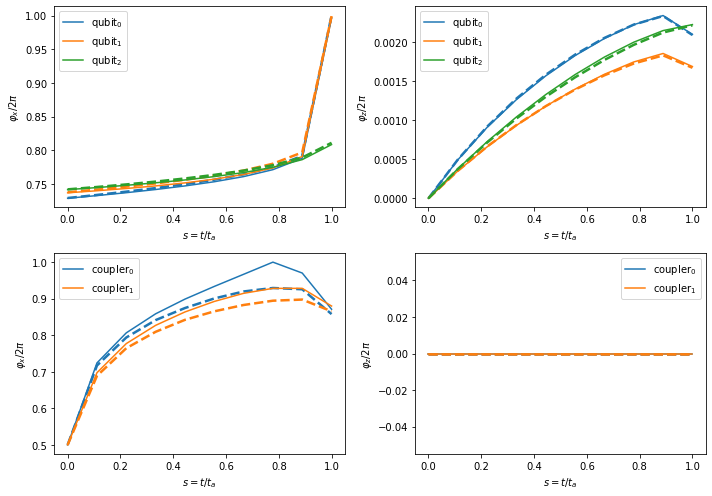

In [21]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_num["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_num["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_num["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_num["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

### Check the calculated schedules

Because our system here is small enough for us to be able to perform the full SW, we can calculate the SW schedules that are implemented by the fluxes that we found earlier using the two methods.
We can then compare this we the schedule that we desired to implement.

Below we calculate the schedules that our extracted circuit biases produce, and plot them against our desired schedules.

In [22]:
%%time

ising_sw_from_num = circuit.get_ising_sw(custom_flux_dict_num, verbose=True)
ising_sw_from_pwsw = circuit.get_ising_sw(custom_flux_dict_pwsw, verbose=True)

CPU times: user 25min 39s, sys: 10min 15s, total: 35min 55s
Wall time: 4min 4s


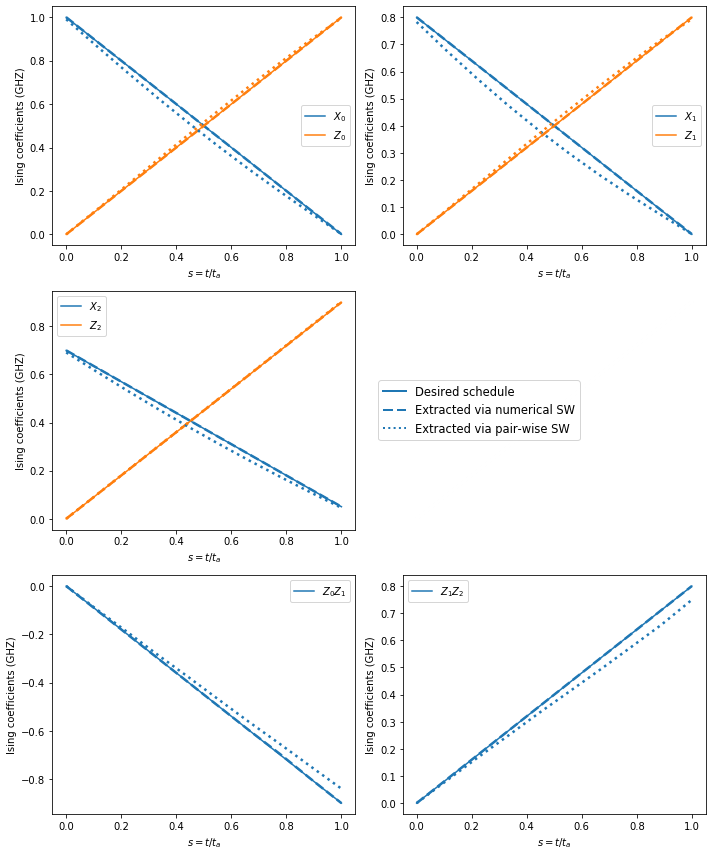

In [23]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(3):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.plot(s, ising_dict["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, ising_dict["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")
    
    plt.plot(s, ising_sw_from_num["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_sw_from_num["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["x_"+str(i)]/2/np.pi, color="C0", ls=':', lw=2.5 )
    plt.plot(s, ising_sw_from_pwsw["z_"+str(i)]/2/np.pi, color="C1", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
ax3 = plt.subplot(3, 2, 4)
plt.axis('off')
plt.plot(s, s, lw=2, label="Desired schedule")
plt.plot(s, s, color="C0", ls=(0, (5, 2)), lw=2, label="Extracted via numerical SW")
plt.plot(s, s, color="C0", ls=":", lw=2, label="Extracted via pair-wise SW")
plt.plot(s, s, color='w', lw=4)
plt.legend(bbox_to_anchor=(-0.1, 0.5), loc='center left', fontsize=11.5)
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
    plt.plot(s, ising_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]))
    
    
    plt.plot(s, ising_sw_from_num["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.plot(s, ising_sw_from_pwsw["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls=':', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

## Asymmetry correction for fluxes

If in the beginning when we are creating the circuit objects, we use asymmetric junctions by setting `d` to a nonzero value, then all the methods automatically take that into account.
More specifically, the schedule extraction methods of `get_ising_[]` will give the schedules for asymmetric junctions which could yield for example skewed z-fields.
For the flux extraction methods of `get_custom_fluxes_[]`, they automatically give the fluxes that are corrected for asymmetry of all circuit junctions.

Nevertheless, one can also create another circuit object that has asymmetric elements and use the `_apply_asymmetry_shifts` method to calculate the fluxes for asymmetric circuits.
Below we give an example of that for junctions that have 10% asymmetry:

In [24]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.1
qubit0_asym = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1_asym = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit2_asym = sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.1
coupler01_asym = sims.Coupler(i_sigma, c_sigma, lc, d)
coupler12_asym = sims.Coupler(i_sigma, c_sigma, lc, d)

elements_asym = [qubit0_asym, coupler01_asym, qubit1_asym, coupler12_asym, qubit2_asym]

# couple qubits in a chain
m = 65; m_mat = np.zeros((5, 5));
m_mat[0, 1] = m; m_mat[1, 2] = m;
m_mat[2, 3] = -m; m_mat[3, 4] = m;
m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([6, 3, 6, 3, 6])

circuit_asym = sims.MultiQubit(elements_asym, m_mat, trunc_vec)

We just use the linearly changing fluxes that we used earlier and correct them for asymmetric junctions.

In [27]:
phi_dict_asym = circuit_asym._apply_asymmetry_shifts(phi_dict)
s = np.linspace(0, 1, phi_dict["points"])

We can now compare the original fluxes of junction-symmetric elements with the fluxes for junction-asymmetric elements. 
The solid lines are the fluxes for symmetric junctions, and dashed lines are fluxes for asymmetric junction that should yield the same Ising schedules as the case of the symmetric circuit

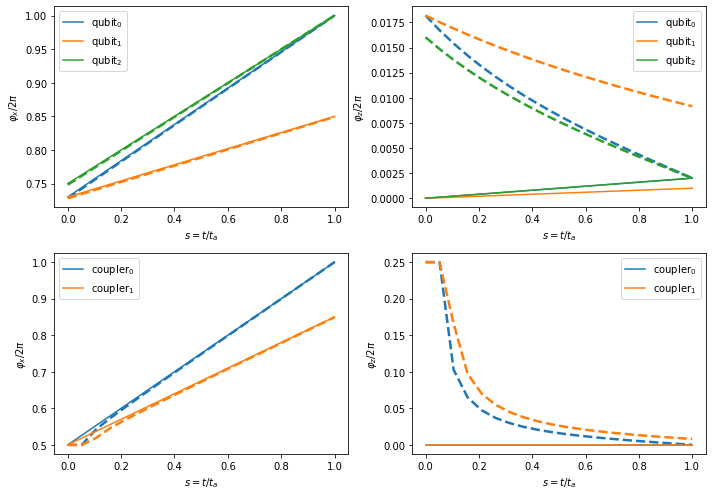

In [29]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, phi_dict["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, phi_dict_asym["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, phi_dict["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    plt.plot(s, phi_dict_asym["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)
# plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, phi_dict["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, phi_dict_asym["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, phi_dict["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    plt.plot(s, phi_dict_asym["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
# plt.savefig("./plots/fluxes_asym.pdf", bbox_inches="tight")
plt.show()

These asymmetry shifted fluxes should yield the exact same schedule as the ones for the symmetric junctions.
We compare that by using the asymmetry adjusted fluxes for the asymmetric circuit object to calculate the Ising schedules.
We then compare it to the Ising schedules of symmetric circuit for junction-symmetric fluxes.

In [30]:
%%time

ising_sw_asym = circuit_asym.get_ising_sw(phi_dict_asym, verbose=True)

CPU times: user 23min 37s, sys: 7min 44s, total: 31min 21s
Wall time: 3min 31s


Solid lines are the schedules for junction-symmetric circuits and fluxes, and dashed lines are Ising schedules for junction-asymmetric circuits and fluxes, and we see that they are the same.
This means our asymmetry correction procedure works as expected and produces the exact same schedules as the case of the symmetric junctions.

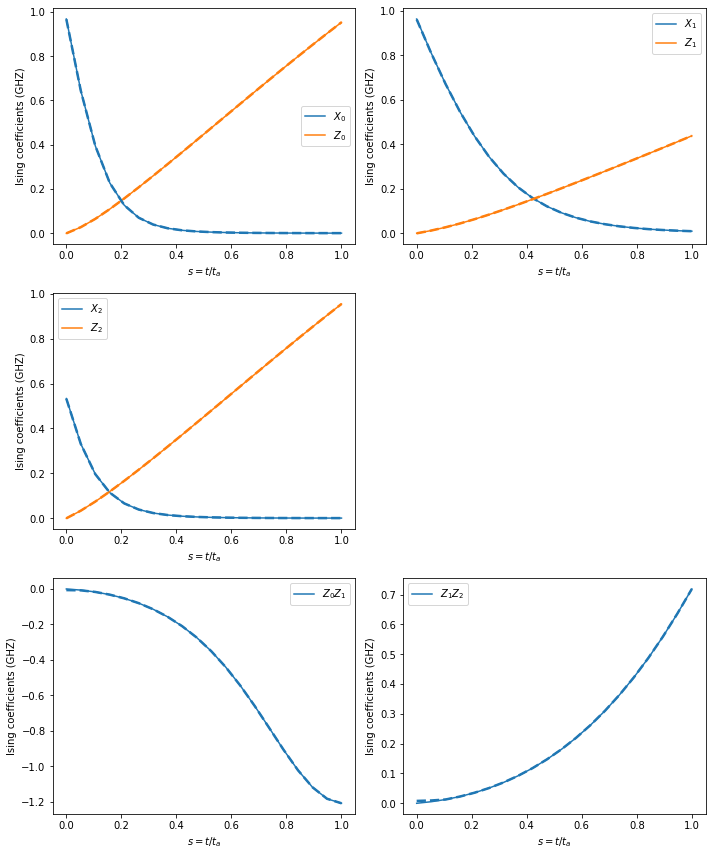

In [31]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(3):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.plot(s, ising_sw_dict["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, ising_sw_dict["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")
    
    plt.plot(s, ising_sw_asym["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_sw_asym["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
    plt.plot(s, ising_sw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]))
    
    plt.plot(s, ising_sw_asym["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

## Testbed examples

In the examples below, we consider different sizes of square grids of qubits, and will calculate the circuit fluxes that yields an Ising schedule that linearly changes as a function of anneal time (as an example).

We only use pair-wise SW method here since these systems sizes can not fit into typical memories anymore. The goal is to get an estimate of the time it takes to calculate these circuit flux biases.

### Grid of 2x2 qubits

4 qubits and 4 couplers. Time it takes to calculate fluxes for 10 points: 2 mins 40 secs

In [29]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubits = [sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d) for i in range(4)]

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
couplers = [sims.Coupler(i_sigma, c_sigma, lc, d) for i in range(4)]

elements = qubits + couplers

trunc_vec = [(element.type=='qubit')*6 + (element.type=='coupler')*3 for element in elements]


m = 65; m_mat = np.zeros((len(elements), len(elements)));

m_mat[0, 4] = m; m_mat[1, 4] = m;
m_mat[1, 5] = m; m_mat[3, 5] = m;
m_mat[3, 6] = m; m_mat[2, 6] = m;
m_mat[2, 7] = m; m_mat[0, 7] = m;

m_mat = -(m_mat + m_mat.T)

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [30]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

for i in range(len(qubits)):
    ising_dict["x_" + str(i)] = np.linspace(1, 0, pts)*2*np.pi

for i in range(len(qubits)):
    ising_dict["z_" + str(i)] = np.linspace(0, 1, pts)*2*np.pi
    
for i, coupler_index in enumerate(circuit.coupler_indices):
    index_of_coupled = np.nonzero(circuit.mutual_mat[coupler_index])[0]
    index_0 = np.argwhere(circuit.qubit_indices == index_of_coupled[0])[0, 0]
    index_1 = np.argwhere(circuit.qubit_indices == index_of_coupled[1])[0, 0]
    
    ising_dict["zz_" + str(index_0) + ',' + str(index_1)] = -np.linspace(0, 1, pts)*2*np.pi

In [31]:
ising_dict.keys()

dict_keys(['points', 'x_0', 'x_1', 'x_2', 'x_3', 'z_0', 'z_1', 'z_2', 'z_3', 'zz_0,1', 'zz_1,3', 'zz_2,3', 'zz_0,2'])

In [32]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 4
point #9 single qubit residuals: 
 [-9.39698316e-02  6.96331195e-05] 

calculating qubit biases for qubit 2 of 4


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.39698316e-02  6.96331195e-05] 

calculating qubit biases for qubit 3 of 4
point #9 single qubit residuals: 
 [-9.39698316e-02  6.96331195e-05] 

calculating qubit biases for qubit 4 of 4
point #9 single qubit residuals: 
 [-9.39698316e-02  6.96331195e-05] 


 calculating coupler bias for coupler 1 of 4
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 4
schedule point 10 / 10
 calculating coupler bias for coupler 3 of 4
schedule point 10 / 10
 calculating coupler bias for coupler 4 of 4
CPU times: user 15min 1s, sys: 16min 7s, total: 31min 8s
Wall time: 2min 40s


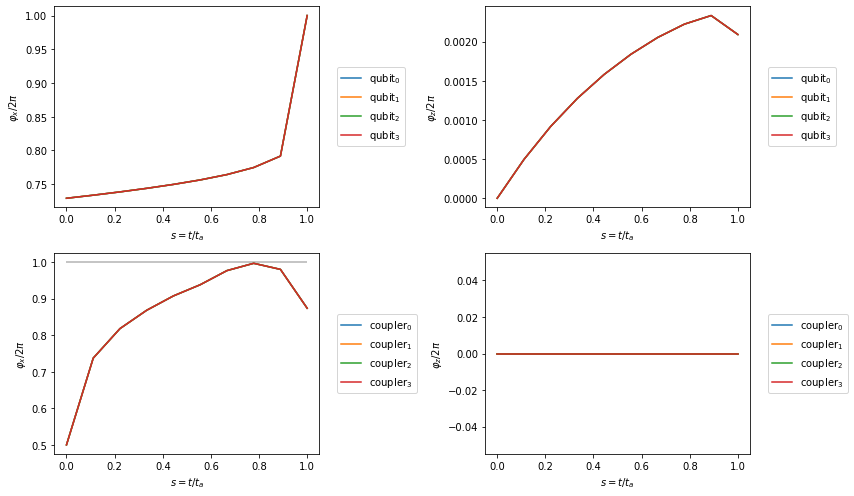

In [32]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((12, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax3 = plt.subplot(2, 2, 3)
plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    
plt.tight_layout()
plt.show()

### Grid of 3x3 qubits

9 qubits and 12 couplers. Time it takes to calculate fluxes for 10 points: 7 mins 7 secs

In [23]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubits = [sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d) for i in range(9)]

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
couplers = [sims.Coupler(i_sigma, c_sigma, lc, d) for i in range(12)]

elements = qubits + couplers

trunc_vec = [(element.type=='qubit')*6 + (element.type=='coupler')*3 for element in elements]


m = 65; m_mat = np.zeros((len(elements), len(elements)));

m_mat[0, 9] = m; m_mat[9, 1] = m;
m_mat[1, 10] = m; m_mat[10, 2] = m;
m_mat[0, 11] = m; m_mat[11, 3] = m;
m_mat[1, 12] = m; m_mat[12, 4] = m;
m_mat[2, 13] = m; m_mat[13, 5] = m;
m_mat[3, 14] = m; m_mat[14, 4] = m;
m_mat[4, 15] = m; m_mat[15, 5] = m;
m_mat[3, 16] = m; m_mat[16, 6] = m;
m_mat[4, 17] = m; m_mat[17, 7] = m;
m_mat[5, 18] = m; m_mat[18, 8] = m;
m_mat[6, 19] = m; m_mat[19, 7] = m;
m_mat[7, 20] = m; m_mat[20, 8] = m;

m_mat = -(m_mat + m_mat.T)

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [24]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

for i in range(len(qubits)):
    ising_dict["x_" + str(i)] = np.linspace(1, 0, pts)*2*np.pi

for i in range(len(qubits)):
    ising_dict["z_" + str(i)] = np.linspace(0, 1, pts)*2*np.pi
    
for i, coupler_index in enumerate(circuit.coupler_indices):
    index_of_coupled = np.nonzero(circuit.mutual_mat[coupler_index])[0]
    index_0 = np.argwhere(circuit.qubit_indices == index_of_coupled[0])[0, 0]
    index_1 = np.argwhere(circuit.qubit_indices == index_of_coupled[1])[0, 0]
    
    ising_dict["zz_" + str(index_0) + ',' + str(index_1)] = -np.linspace(0, 1, pts)*2*np.pi

In [25]:
ising_dict.keys()

dict_keys(['points', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'zz_0,1', 'zz_1,2', 'zz_0,3', 'zz_1,4', 'zz_2,5', 'zz_3,4', 'zz_4,5', 'zz_3,6', 'zz_4,7', 'zz_5,8', 'zz_6,7', 'zz_7,8'])

In [37]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 9
point #9 single qubit residuals: 
 [-9.39700526e-02  6.99669645e-05] 

calculating qubit biases for qubit 2 of 9


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.38367336e-02  6.05144680e-05] 

calculating qubit biases for qubit 3 of 9


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.49 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.39700526e-02  6.99669645e-05] 

calculating qubit biases for qubit 4 of 9
point #9 single qubit residuals: 
 [-9.38367336e-02  6.05144680e-05] 

calculating qubit biases for qubit 5 of 9
point #9 single qubit residuals: 
 [-9.37070664e-02  6.64338803e-05] 

calculating qubit biases for qubit 6 of 9
point #9 single qubit residuals: 
 [-9.38367336e-02  6.05144680e-05] 

calculating qubit biases for qubit 7 of 9
point #9 single qubit residuals: 
 [-9.39700526e-02  6.99669645e-05] 

calculating qubit biases for qubit 8 of 9
point #9 single qubit residuals: 
 [-9.38367336e-02  6.05144680e-05] 

calculating qubit biases for qubit 9 of 9
point #9 single qubit residuals: 
 [-9.39700526e-02  6.99669645e-05] 


 calculating coupler bias for coupler 1 of 12
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 12
schedule point 10 / 10
 calculating coupler bias for coupler 3 of 12
schedule point 10 / 10
 calculating coupler bias for coupler 4 of 

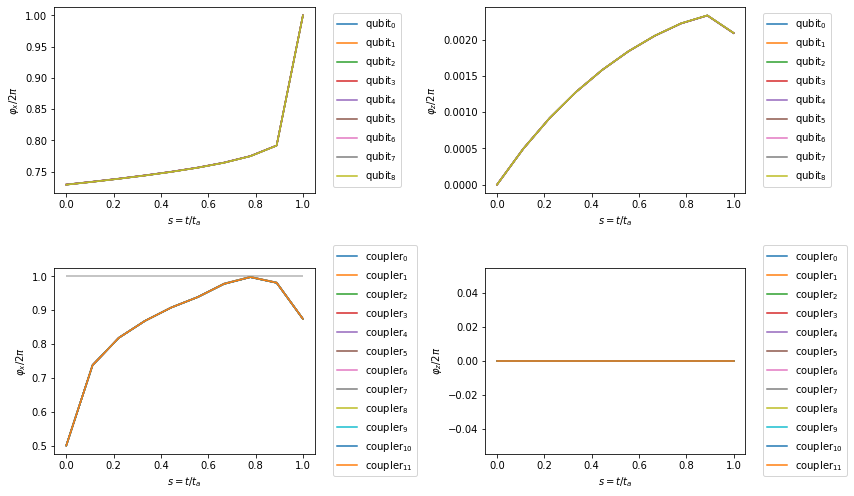

In [41]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((12, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, label=r"qubit$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax3 = plt.subplot(2, 2, 3)
plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, label=r"coupler$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    
plt.tight_layout()
plt.show()

### Grid of 4x4 qubits

16 qubits and 24 couplers. Time it takes to calculate fluxes for 10 points: 15 mins

In [26]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubits = [sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d) for i in range(16)]

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
couplers = [sims.Coupler(i_sigma, c_sigma, lc, d) for i in range(24)]

elements = qubits + couplers

trunc_vec = [(element.type=='qubit')*6 + (element.type=='coupler')*3 for element in elements]


m = 65; m_mat = np.zeros((len(elements), len(elements)));

m_mat[0, 16] = m; m_mat[16, 1] = m;
m_mat[1, 17] = m; m_mat[17, 2] = m;
m_mat[2, 18] = m; m_mat[18, 3] = m;
m_mat[0, 19] = m; m_mat[19, 4] = m;
m_mat[1, 20] = m; m_mat[20, 5] = m;
m_mat[2, 21] = m; m_mat[21, 6] = m;
m_mat[3, 22] = m; m_mat[22, 7] = m;
m_mat[4, 23] = m; m_mat[23, 5] = m;
m_mat[5, 24] = m; m_mat[24, 6] = m;
m_mat[6, 25] = m; m_mat[25, 7] = m;
m_mat[4, 26] = m; m_mat[26, 8] = m;
m_mat[5, 27] = m; m_mat[27, 9] = m;
m_mat[6, 28] = m; m_mat[28, 10] = m;
m_mat[7, 29] = m; m_mat[29, 11] = m;
m_mat[8, 30] = m; m_mat[30, 9] = m;
m_mat[9, 31] = m; m_mat[31, 10] = m;
m_mat[10, 32] = m; m_mat[32, 11] = m;
m_mat[8, 33] = m; m_mat[33, 12] = m;
m_mat[9, 34] = m; m_mat[34, 13] = m;
m_mat[10, 35] = m; m_mat[35, 14] = m;
m_mat[11, 36] = m; m_mat[36, 15] = m;
m_mat[12, 37] = m; m_mat[37, 13] = m;
m_mat[13, 38] = m; m_mat[38, 14] = m;
m_mat[14, 39] = m; m_mat[39, 15] = m;

m_mat = -(m_mat + m_mat.T)

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [27]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

for i in range(len(qubits)):
    ising_dict["x_" + str(i)] = np.linspace(1, 0, pts)*2*np.pi

for i in range(len(qubits)):
    ising_dict["z_" + str(i)] = np.linspace(0, 1, pts)*2*np.pi
    
for i, coupler_index in enumerate(circuit.coupler_indices):
    index_of_coupled = np.nonzero(circuit.mutual_mat[coupler_index])[0]
    index_0 = np.argwhere(circuit.qubit_indices == index_of_coupled[0])[0, 0]
    index_1 = np.argwhere(circuit.qubit_indices == index_of_coupled[1])[0, 0]
    
    ising_dict["zz_" + str(index_0) + ',' + str(index_1)] = -np.linspace(0, 1, pts)*2*np.pi

In [28]:
ising_dict.keys()

dict_keys(['points', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'zz_0,1', 'zz_1,2', 'zz_2,3', 'zz_0,4', 'zz_1,5', 'zz_2,6', 'zz_3,7', 'zz_4,5', 'zz_5,6', 'zz_6,7', 'zz_4,8', 'zz_5,9', 'zz_6,10', 'zz_7,11', 'zz_8,9', 'zz_9,10', 'zz_10,11', 'zz_8,12', 'zz_9,13', 'zz_10,14', 'zz_11,15', 'zz_12,13', 'zz_13,14', 'zz_14,15'])

In [46]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 16
point #9 single qubit residuals: 
 [-9.39697629e-02  7.16527791e-05] 

calculating qubit biases for qubit 2 of 16


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.38366977e-02  6.55645349e-05] 

calculating qubit biases for qubit 3 of 16


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.49 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.38366977e-02  6.55645349e-05] 

calculating qubit biases for qubit 4 of 16
point #9 single qubit residuals: 
 [-9.39697629e-02  7.16527791e-05] 

calculating qubit biases for qubit 5 of 16
point #9 single qubit residuals: 
 [-9.38366977e-02  6.55645349e-05] 

calculating qubit biases for qubit 6 of 16
point #9 single qubit residuals: 
 [-9.37070031e-02  6.46754642e-05] 

calculating qubit biases for qubit 7 of 16
point #9 single qubit residuals: 
 [-9.37070031e-02  6.46754642e-05] 

calculating qubit biases for qubit 8 of 16
point #9 single qubit residuals: 
 [-9.38366977e-02  6.55645349e-05] 

calculating qubit biases for qubit 9 of 16
point #9 single qubit residuals: 
 [-9.38366977e-02  6.55645349e-05] 

calculating qubit biases for qubit 10 of 16
point #9 single qubit residuals: 
 [-9.37070031e-02  6.46754642e-05] 

calculating qubit biases for qubit 11 of 16
point #9 single qubit residuals: 
 [-9.37070010e-02  6.57720854e-05] 

calculating qub

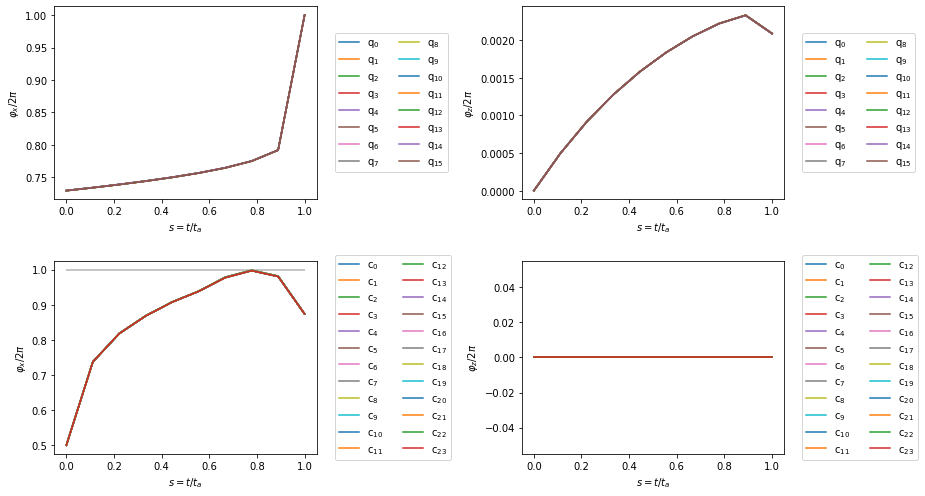

In [54]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((13, 7))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, label=r"q$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, label=r"q$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
    
ax3 = plt.subplot(2, 2, 3)
plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, label=r"c$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, label=r"c$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
    
    
plt.tight_layout()
plt.show()

### Grid of 5x5 qubits

25 qubits and 40 couplers. Time it takes to calculate fluxes for 10 points: 23 mins and 30 secs

In [51]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubits = [sims.CSFQ(i_c, c_shunt, c_z, lq, alpha, d) for i in range(25)]

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
couplers = [sims.Coupler(i_sigma, c_sigma, lc, d) for i in range(40)]

elements = qubits + couplers

trunc_vec = [(element.type=='qubit')*6 + (element.type=='coupler')*3 for element in elements]


m = 65; m_mat = np.zeros((len(elements), len(elements)));

m_mat[0, 25] = m; m_mat[25, 1] = m;
m_mat[1, 26] = m; m_mat[26, 2] = m;
m_mat[2, 27] = m; m_mat[27, 3] = m;
m_mat[3, 28] = m; m_mat[28, 4] = m;
m_mat[0, 29] = m; m_mat[29, 5] = m;
m_mat[1, 30] = m; m_mat[30, 6] = m;
m_mat[2, 31] = m; m_mat[31, 7] = m;
m_mat[3, 32] = m; m_mat[32, 8] = m;
m_mat[4, 33] = m; m_mat[33, 9] = m;
m_mat[5, 34] = m; m_mat[34, 6] = m;
m_mat[6, 35] = m; m_mat[35, 7] = m;
m_mat[7, 36] = m; m_mat[36, 8] = m;
m_mat[8, 37] = m; m_mat[37, 9] = m;
m_mat[5, 38] = m; m_mat[38, 10] = m;
m_mat[6, 39] = m; m_mat[39, 11] = m;
m_mat[7, 40] = m; m_mat[40, 12] = m;
m_mat[8, 41] = m; m_mat[41, 13] = m;
m_mat[9, 42] = m; m_mat[42, 14] = m;
m_mat[10, 43] = m; m_mat[43, 11] = m;
m_mat[11, 44] = m; m_mat[44, 12] = m;
m_mat[12, 45] = m; m_mat[45, 13] = m;
m_mat[13, 46] = m; m_mat[46, 14] = m;
m_mat[10, 47] = m; m_mat[47, 15] = m;
m_mat[11, 48] = m; m_mat[48, 16] = m;
m_mat[12, 49] = m; m_mat[49, 17] = m;
m_mat[13, 50] = m; m_mat[50, 18] = m;
m_mat[14, 51] = m; m_mat[51, 19] = m;
m_mat[15, 52] = m; m_mat[52, 16] = m;
m_mat[16, 53] = m; m_mat[53, 17] = m;
m_mat[17, 54] = m; m_mat[54, 18] = m;
m_mat[18, 55] = m; m_mat[55, 19] = m;
m_mat[15, 56] = m; m_mat[56, 20] = m;
m_mat[16, 57] = m; m_mat[57, 21] = m;
m_mat[17, 58] = m; m_mat[58, 22] = m;
m_mat[18, 59] = m; m_mat[59, 23] = m;
m_mat[19, 60] = m; m_mat[60, 24] = m;
m_mat[20, 61] = m; m_mat[61, 21] = m;
m_mat[21, 62] = m; m_mat[62, 22] = m;
m_mat[22, 63] = m; m_mat[63, 23] = m;
m_mat[23, 64] = m; m_mat[64, 24] = m;

m_mat = -(m_mat + m_mat.T)

circuit = sims.MultiQubit(elements, m_mat, trunc_vec)

In [52]:
ising_dict = {}; pts = 10;
s = np.linspace(0, 1, pts)
ising_dict["points"] = pts

for i in range(len(qubits)):
    ising_dict["x_" + str(i)] = np.linspace(1, 0, pts)*2*np.pi

for i in range(len(qubits)):
    ising_dict["z_" + str(i)] = np.linspace(0, 1, pts)*2*np.pi
    
for i, coupler_index in enumerate(circuit.coupler_indices):
    index_of_coupled = np.nonzero(circuit.mutual_mat[coupler_index])[0]
    index_0 = np.argwhere(circuit.qubit_indices == index_of_coupled[0])[0, 0]
    index_1 = np.argwhere(circuit.qubit_indices == index_of_coupled[1])[0, 0]
    
    ising_dict["zz_" + str(index_0) + ',' + str(index_1)] = -np.linspace(0, 1, pts)*2*np.pi

In [53]:
ising_dict.keys()

dict_keys(['points', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'z_16', 'z_17', 'z_18', 'z_19', 'z_20', 'z_21', 'z_22', 'z_23', 'z_24', 'zz_0,1', 'zz_1,2', 'zz_2,3', 'zz_3,4', 'zz_0,5', 'zz_1,6', 'zz_2,7', 'zz_3,8', 'zz_4,9', 'zz_5,6', 'zz_6,7', 'zz_7,8', 'zz_8,9', 'zz_5,10', 'zz_6,11', 'zz_7,12', 'zz_8,13', 'zz_9,14', 'zz_10,11', 'zz_11,12', 'zz_12,13', 'zz_13,14', 'zz_10,15', 'zz_11,16', 'zz_12,17', 'zz_13,18', 'zz_14,19', 'zz_15,16', 'zz_16,17', 'zz_17,18', 'zz_18,19', 'zz_15,20', 'zz_16,21', 'zz_17,22', 'zz_18,23', 'zz_19,24', 'zz_20,21', 'zz_21,22', 'zz_22,23', 'zz_23,24'])

In [54]:
%%time

custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_dict, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 25
point #9 single qubit residuals: 
 [-9.39697669e-02  6.67331771e-05] 

calculating qubit biases for qubit 2 of 25


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.50 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.38366949e-02  6.97988200e-05] 

calculating qubit biases for qubit 3 of 25


/home/mostafa/Dropbox/Research/FluQS/codes/quack/quack/schedule/one_qubit.py:622: UserWarning: For the point #9, solver found solutions that are not optimal. The relative error is 1.49 % for single qubit residuals
  ).format(i, rel_error * 100)


point #9 single qubit residuals: 
 [-9.38366618e-02  6.94571549e-05] 

calculating qubit biases for qubit 4 of 25
point #9 single qubit residuals: 
 [-9.38366949e-02  6.97988200e-05] 

calculating qubit biases for qubit 5 of 25
point #9 single qubit residuals: 
 [-9.39697669e-02  6.67331771e-05] 

calculating qubit biases for qubit 6 of 25
point #9 single qubit residuals: 
 [-9.38366949e-02  6.97988200e-05] 

calculating qubit biases for qubit 7 of 25
point #9 single qubit residuals: 
 [-9.37070004e-02  6.64560752e-05] 

calculating qubit biases for qubit 8 of 25
point #9 single qubit residuals: 
 [-9.37069656e-02  6.79788608e-05] 

calculating qubit biases for qubit 9 of 25
point #9 single qubit residuals: 
 [-9.37070004e-02  6.64560752e-05] 

calculating qubit biases for qubit 10 of 25
point #9 single qubit residuals: 
 [-9.38366949e-02  6.97988200e-05] 

calculating qubit biases for qubit 11 of 25
point #9 single qubit residuals: 
 [-9.38366618e-02  6.94571549e-05] 

calculating qub

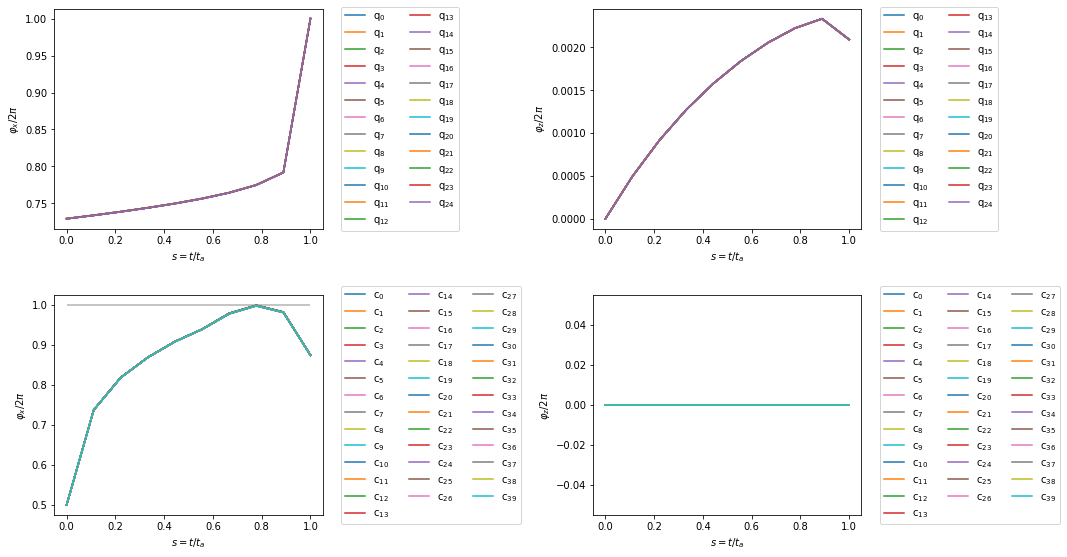

In [58]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((15, 8))

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, label=r"q$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, label=r"q$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
    
ax3 = plt.subplot(2, 2, 3)
plt.hlines(1, 0, 1, alpha=0.3)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, label=r"c$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=3)
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, label=r"c$_{{{0:d}}}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=3)
    
    
plt.tight_layout()
plt.show()

### Analysis of computational scaling

The scaling analysis below shows that as expected, the time for calculating fluxes using this module and the pair-wise SW method scales linearly with the size of the system.

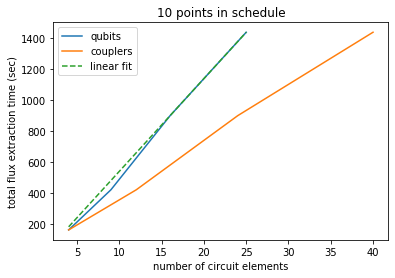

In [59]:
size_q = np.array([4, 9, 16, 25])
size_c = np.array([4, 12, 24, 40])
time = np.array([160, 7*60, 15*60, 24*60])

plt.plot(size_q, time, label="qubits")
plt.plot(size_c, time, label="couplers")
plt.plot(size_q, size_q*60-60, '--', label="linear fit")
plt.xlabel("number of circuit elements"); plt.ylabel("total flux extraction time (sec)")
plt.title("10 points in schedule")
plt.legend()
plt.show()